In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import argparse
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm as tqdm

In [3]:
import sys

sys.path.append('..')
from src.configs import config
from src.modules.srgan import data_utils as ds
from src.modules.srgan.data_utils import HPATrainDatasetFromFolder, HPAValDatasetFromFolder, \
    RecursionTrainDatasetFromFolder, RecursionValDatasetFromFolder, display_transform
from src.modules.srgan.loss import GeneratorLoss
from src.modules.srgan.model import Generator, Discriminator
import src.modules.srgan.ssim as pytorch_ssim

%load_ext autoreload
%autoreload 2

In [4]:
def visualise(lr, hr, pred):
    plt.figure(figsize=(21, 7))
    plt.subplot(131)
    a = plt.imshow(cv2.resize(lr, hr.shape[:2][::-1]))
    plt.axis('off')
    plt.subplot(132)
    a = plt.imshow(hr)
    plt.axis('off')
    plt.subplot(133)
    a = plt.imshow(pred)
    plt.axis('off')
    plt.show()

In [5]:
def get_dataloaders(train_data_dir, valid_data_dir, dataset_type='hpa', **kwargs):
    # Load test and train sets
    if dataset_type == 'hpa':
        train_set = HPATrainDatasetFromFolder(
            train_data_dir, crop_size=config.CROP_SIZE,
            upscale_factor=config.UPSCALE_FACTOR,
            colorisation=config.COLORISATION, **kwargs)
        val_set = HPAValDatasetFromFolder(
            valid_data_dir, upscale_factor=config.UPSCALE_FACTOR,
            colorisation=config.COLORISATION, **kwargs)
        
    elif dataset_type == 'rx':
        train_set = RecursionTrainDatasetFromFolder(
            train_data_dir, crop_size=config.CROP_SIZE,
            upscale_factor=config.UPSCALE_FACTOR,
            colorisation=config.COLORISATION, **kwargs)
        val_set = RecursionValDatasetFromFolder(
            valid_data_dir, upscale_factor=config.UPSCALE_FACTOR,
            colorisation=config.COLORISATION, **kwargs)
        
    else:
        raise ValueError('Unknown dataset type ' + dataset_type)

    train_loader = DataLoader(dataset=train_set, num_workers=8, batch_size=config.PARAMS.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset=val_set, num_workers=8, batch_size=1, shuffle=False)

    return train_loader, val_loader

In [6]:
def generate_image(generator, img):
    input_img = Variable(img)
    if torch.cuda.is_available():
        input_img = input_img.cuda()
    output_img = generator(input_img)
    return output_img.data.cpu().squeeze(0)

In [7]:
class Learner:
    def __init__(self, perception_enabled=True):
        # Initialize the networks
        self.netG = Generator(config.UPSCALE_FACTOR, **config.PARAMS.COLORISATION)
        print('# generator parameters:', sum(param.numel() for param in self.netG.parameters()))
        self.netD = Discriminator(**config.PARAMS.COLORISATION)
        print('# discriminator parameters:', sum(param.numel() for param in self.netD.parameters()))

        self.generator_criterion = GeneratorLoss(perception_enabled=perception_enabled, **config.PARAMS.COLORISATION)

        if torch.cuda.is_available():
            self.netG.cuda()
            self.netD.cuda()
            self.generator_criterion.cuda()

        self.optimizerG = optim.Adam(self.netG.parameters(), weight_decay=config.PARAMS.WD)
        self.optimizerD = optim.Adam(self.netD.parameters(), weight_decay=config.PARAMS.WD)

        self.results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

    def train_on_epoch(self, train_loader, num_epochs, epoch=0):
        train_bar = tqdm(train_loader)
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

        self.netG.train()
        self.netD.train()
        for i, (data, target) in enumerate(train_bar):
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size

            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target)
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)
            if torch.cuda.is_available():
                z = z.cuda()
            fake_img = self.netG(z)

            self.netD.zero_grad()
            real_out = self.netD(real_img).mean()
            fake_out = self.netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.netD.parameters(), config.PARAMS.GCLIP)
            self.optimizerD.step()

            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            self.netG.zero_grad()
            g_loss = self.generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.netG.parameters(), config.PARAMS.GCLIP)
            self.optimizerG.step()

            fake_img = self.netG(z)
            fake_out = self.netD(fake_img).mean()

            g_loss = self.generator_criterion(fake_out, fake_img, real_img)
            running_results['g_loss'] += g_loss.data.item() * batch_size
            d_loss = 1 - real_out + fake_out
            running_results['d_loss'] += d_loss.data.item() * batch_size
            running_results['d_score'] += real_out.data.item() * batch_size
            running_results['g_score'] += fake_out.data.item() * batch_size

            train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
                epoch, num_epochs, running_results['d_loss'] / running_results['batch_sizes'],
                running_results['g_loss'] / running_results['batch_sizes'],
                running_results['d_score'] / running_results['batch_sizes'],
                running_results['g_score'] / running_results['batch_sizes']))

            if config.PARAMS.MAX_STEPS_PER_EPOCH > 0 and config.PARAMS.MAX_STEPS_PER_EPOCH < i:
                break

        self.results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        self.results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        self.results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        self.results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        

    def validate(self, val_loader, epoch=0, process_data_dir=None):
        with torch.no_grad():
            self.netG.eval()

            out_path = process_data_dir + '/training_results/SRF_' + str(config.UPSCALE_FACTOR) + '/'
            if not os.path.exists(out_path):
                os.makedirs(out_path)
                
            val_bar = tqdm(val_loader)
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []
            
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = Variable(val_lr)
                hr = Variable(val_hr)
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = self.netG(lr)

                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size
                batch_ssim = pytorch_ssim.ssim(sr, hr).data.item()
                valing_results['ssims'] += batch_ssim * batch_size
                valing_results['psnr'] = 10 * log10(1 / (valing_results['mse'] / valing_results['batch_sizes']))
                valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
                val_bar.set_description(
                    desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                        valing_results['psnr'], valing_results['ssim']))

                val_images.extend(
                    [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                     display_transform()(sr.data.cpu().squeeze(0))])

            val_images = torch.stack(val_images)
            val_images = torch.chunk(val_images, val_images.size(0) // 15)
            val_save_bar = tqdm(val_images, desc='[saving training results]')
            
            index = 1
            print(out_path)
            for image in val_save_bar:
                image = utils.make_grid(image[:, :3], nrow=3, padding=5)
                utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
                index += 1

        # save model parameters
        epochs_path = process_data_dir + '/epochs'
        if not os.path.exists(epochs_path):
            os.makedirs(epochs_path)
            
        torch.save(self.netG.state_dict(), epochs_path +'/netG_epoch_%d_%d.pth' % (config.UPSCALE_FACTOR, epoch))
        torch.save(self.netD.state_dict(), epochs_path + '/netD_epoch_%d_%d.pth' % (config.UPSCALE_FACTOR, epoch))
        # save loss\scores\psnr\ssim
        self.results['psnr'].append(valing_results['psnr'])
        self.results['ssim'].append(valing_results['ssim'])

        if epoch % 1 == 0 and epoch != 0:
            out_path = process_data_dir + '/statistics/'
            if not os.path.exists(out_path):
                os.makedirs(out_path)
            
            data_frame = pd.DataFrame(
                data={'Loss_D': self.results['d_loss'], 'Loss_G': self.results['g_loss'], 'Score_D': self.results['d_score'],
                      'Score_G': self.results['g_score'], 'PSNR': self.results['psnr'], 'SSIM': self.results['ssim']},
                index=range(1, epoch + 1))
            data_frame.to_csv(out_path + 'srf_' + str(config.UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')

In [8]:
def train_SRGAN(learner, train_data_dir, valid_data_dir, process_data_dir,
               dataset_type='hpa', num_epochs=10):
    
    process_data_dir = process_data_dir + '/' + dataset_type

    for epoch in range(1, num_epochs + 1):
        learner.train_on_epoch(train_loader, num_epochs, epoch)
        learner.validate(val_loader, epoch, process_data_dir)

In [9]:
import numpy as np
import cv2

In [10]:
TRAIN_DATA_DIR = '../data/hpa/train'
VAL_DATA_DIR = '../data/hpa/valid'
PROCESS_DATA_DIR = '../srgan_training'

In [11]:
learner = Learner(perception_enabled=False)

# generator parameters: 576138
# discriminator parameters: 5215425


KeyboardInterrupt: 

In [ ]:
train_loader, val_loader = get_dataloaders(TRAIN_DATA_DIR, VAL_DATA_DIR, dataset_type="hpa",
                                           merged_channels=['red', 'green'])

In [ ]:
netG = Generator(config.UPSCALE_FACTOR, **config.PARAMS.COLORISATION)
netG.load_state_dict(torch.load('../srgan_training/hpa/epochs/netG_epoch_2_7.pth'))
if torch.cuda.is_available():
    netG.cuda()
    
out_img_tpl = '../srgan_training/output/output_srf2_epoch7_color_{}.png'
val_images = []

for val_lr, val_hr_restore, val_hr in tqdm(val_loader):
    sr_res = generate_image(netG, val_lr)
    val_images.extend([val_hr_restore.squeeze(0), val_hr.squeeze(0), sr_res])

val_images = torch.stack(val_images)
val_images = torch.chunk(val_images, val_images.size(0) // 15)
val_save_bar = tqdm(val_images, desc='[saving inference]')

index = 1
for image in val_save_bar:
    image = utils.make_grid(image[:, :3], nrow=3, padding=5)
    utils.save_image(image, out_img_tpl.format(index), padding=5)
    index += 1

In [ ]:
train_SRGAN(
    learner, train_loader, val_loader, PROCESS_DATA_DIR, num_epochs=8)

In [11]:
train_loader, val_loader = get_dataloaders(
        TRAIN_DATA_DIR, VAL_DATA_DIR, dataset_type='hpa')

In [12]:
learner = Learner()

# generator parameters: 713481
# discriminator parameters: 5214273


In [13]:
learner.train_on_epoch(train_loader)

  0%|          | 0/1553 [00:00<?, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "../src/modules/srgan/data_utils.py", line 130, in __getitem__
    lr_image = self.lr_transform(hr_image)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 92, in __call__
    return F.to_tensor(pic)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torchvision/transforms/functional.py", line 54, in to_tensor
    raise TypeError('pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


In [13]:
for val_lr, val_hr_restore, val_hr in val_loader:
    break

In [18]:
for lr, hr in train_loader:
    break

In [19]:
a = plt.imshow(lr[0, 0])
plt.colorbar(a)

In [20]:
with torch.no_grad():
    batch_size = lr.size(0)
    lr = Variable(lr)
    if torch.cuda.is_available():
        lr = lr.cuda()

    learner.netG.eval()
    predict = learner.netG(lr)

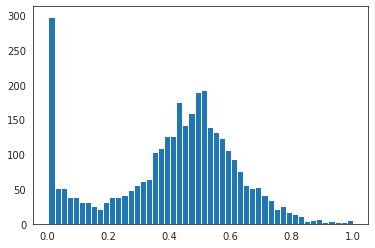

In [27]:
plt.hist(hr.data.cpu().numpy()[0, 0][hr.data.cpu().numpy()[0, 0] != 0], 50);

In [34]:
lr.shape, hr.shape

(torch.Size([20, 1, 88, 88]), torch.Size([20, 4, 176, 176]))

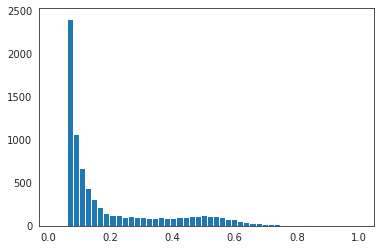

In [28]:
plt.hist(lr.data.cpu().numpy()[0, 0][lr.data.cpu().numpy()[0, 0] != 0], 50);

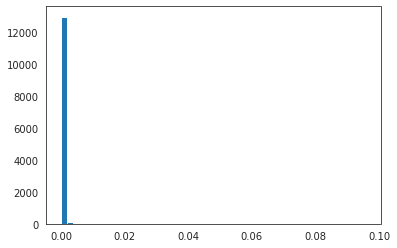

In [21]:
plt.hist(predict.data.cpu().numpy()[0, 0][predict.data.cpu().numpy()[0, 0] != 0], 50);

In [33]:
predict.data.max()

tensor(0.1400, device='cuda:0')

/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


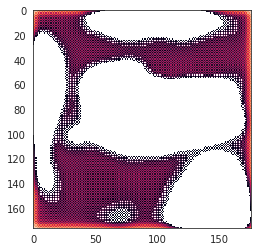

In [39]:
plt.imshow(np.log(predict.data.cpu().numpy()[0, 0]))

# RX

In [11]:
TRAIN_DATA_DIR = '../data/rx/train'
VAL_DATA_DIR = '../data/rx/valid'
PROCESS_DATA_DIR = '../srgan_training'

In [12]:
learner = Learner(perception_enabled=False)

# generator parameters: 576138
# discriminator parameters: 5215425


In [14]:
train_loader, val_loader = get_dataloaders(VAL_DATA_DIR, VAL_DATA_DIR, dataset_type="rx",
                                           merged_channels=['actin', 'nucleoli',
                                                            'mitochondria', 'golgi'])

In [15]:
train_SRGAN(learner, train_loader, val_loader, PROCESS_DATA_DIR + '/kek', num_epochs=4,
            dataset_type="rx")

[1/4] Loss_D: 0.4251 Loss_G: 0.0157 D(x): 0.6610 D(G(z)): 0.0860: 100%|██████████| 17/17 [00:10<00:00,  2.00it/s]
[converting LR images to SR images] PSNR: 22.4589 dB SSIM: 0.4884: 100%|██████████| 330/330 [00:27<00:00, 18.64it/s]
[saving training results]:   0%|          | 0/66 [00:00<?, ?it/s]

../srgan_training/kek/rx/training_results/SRF_2/


[saving training results]: 100%|██████████| 66/66 [00:33<00:00,  1.93it/s]
[2/4] Loss_D: 0.1311 Loss_G: 0.0151 D(x): 0.8709 D(G(z)): 0.0020: 100%|██████████| 17/17 [00:10<00:00,  1.99it/s]
[converting LR images to SR images] PSNR: 21.8257 dB SSIM: 0.4025: 100%|██████████| 330/330 [00:28<00:00, 18.01it/s]
[saving training results]:   0%|          | 0/66 [00:00<?, ?it/s]

../srgan_training/kek/rx/training_results/SRF_2/


[saving training results]: 100%|██████████| 66/66 [00:29<00:00,  2.27it/s]
[3/4] Loss_D: 0.1133 Loss_G: 0.0149 D(x): 0.8893 D(G(z)): 0.0026: 100%|██████████| 17/17 [00:10<00:00,  1.97it/s]
[converting LR images to SR images] PSNR: 21.7666 dB SSIM: 0.2955: 100%|██████████| 330/330 [00:29<00:00, 18.46it/s]
[saving training results]:   0%|          | 0/66 [00:00<?, ?it/s]

../srgan_training/kek/rx/training_results/SRF_2/


[saving training results]: 100%|██████████| 66/66 [00:25<00:00,  2.54it/s]
[4/4] Loss_D: 0.1985 Loss_G: 0.0142 D(x): 0.8404 D(G(z)): 0.0389: 100%|██████████| 17/17 [00:11<00:00,  1.97it/s]
[converting LR images to SR images] PSNR: 21.7747 dB SSIM: 0.2969: 100%|██████████| 330/330 [00:28<00:00, 18.27it/s]
[saving training results]:   0%|          | 0/66 [00:00<?, ?it/s]

../srgan_training/kek/rx/training_results/SRF_2/


[saving training results]: 100%|██████████| 66/66 [00:25<00:00,  2.53it/s]


In [10]:
train_loader, val_loader = get_dataloaders(
        TRAIN_DATA_DIR, VAL_DATA_DIR, dataset_type='rx')

In [11]:
learner = Learner()

# generator parameters: 713481
# discriminator parameters: 5214273


In [12]:
loader, _ = get_dataloaders(
        VAL_DATA_DIR, VAL_DATA_DIR, dataset_type='rx')

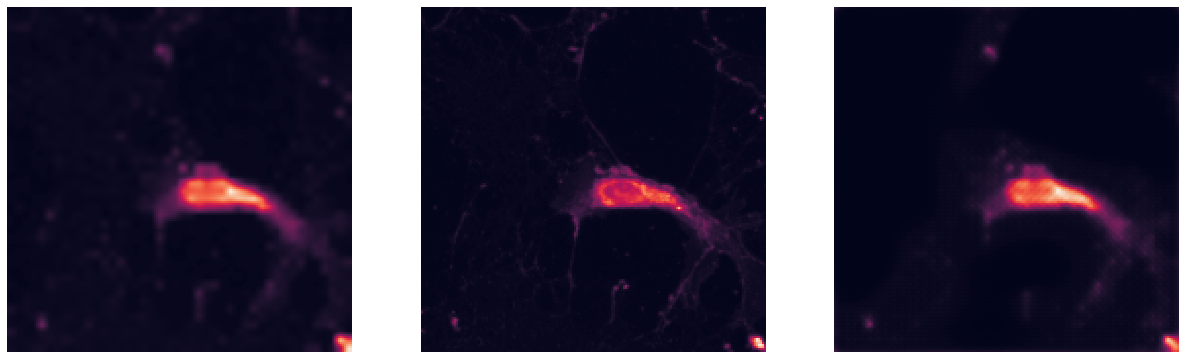

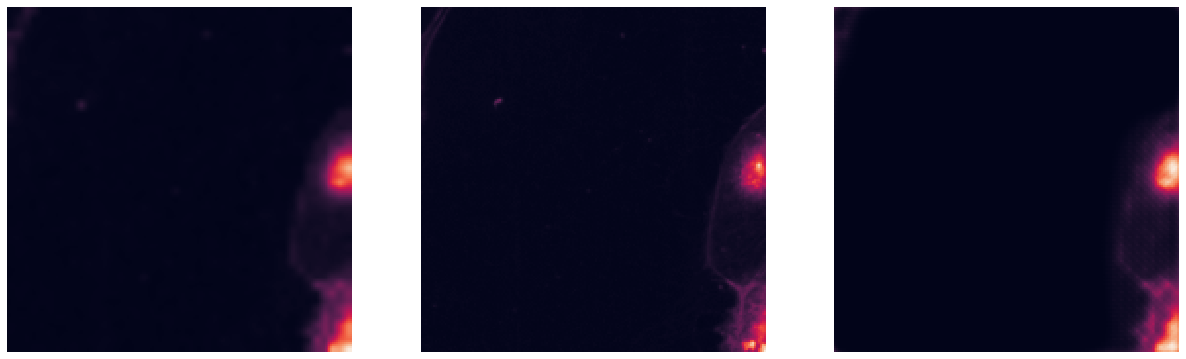

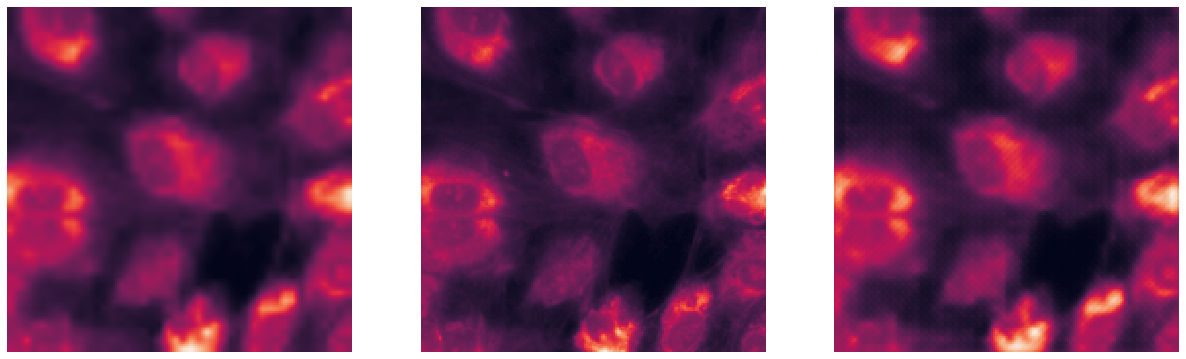

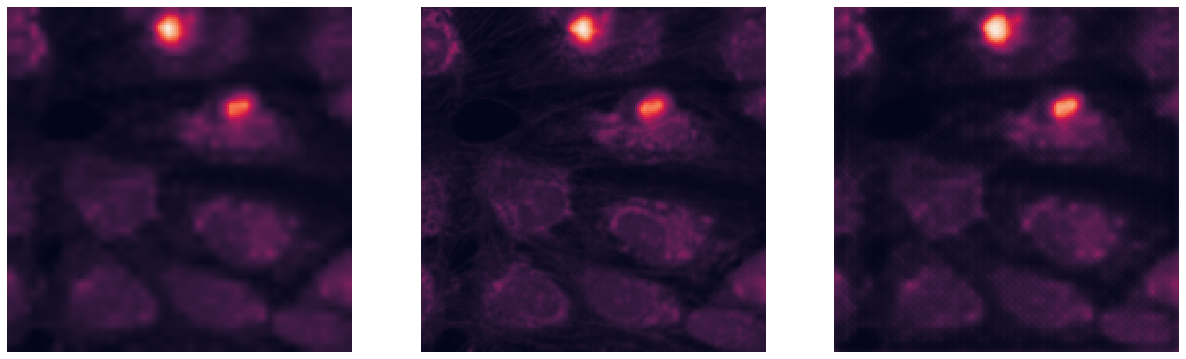

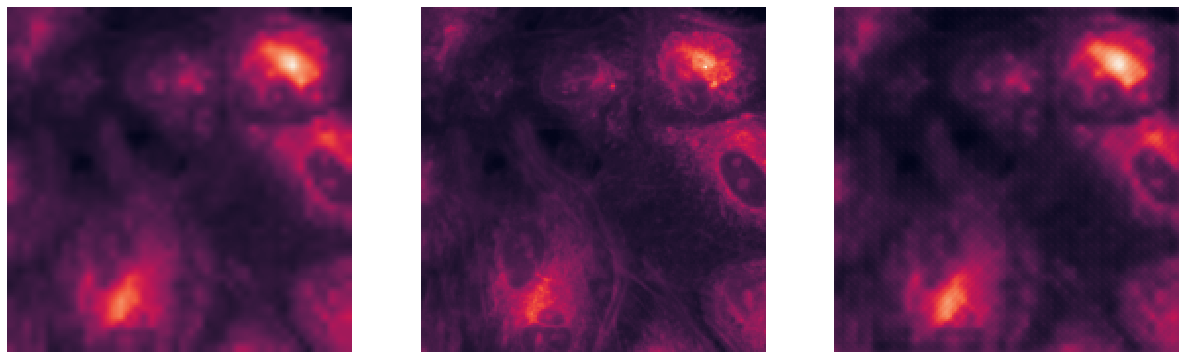

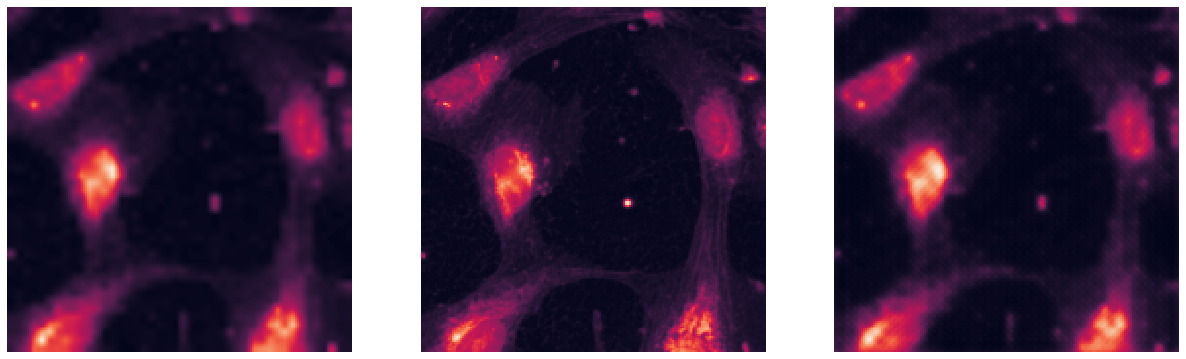

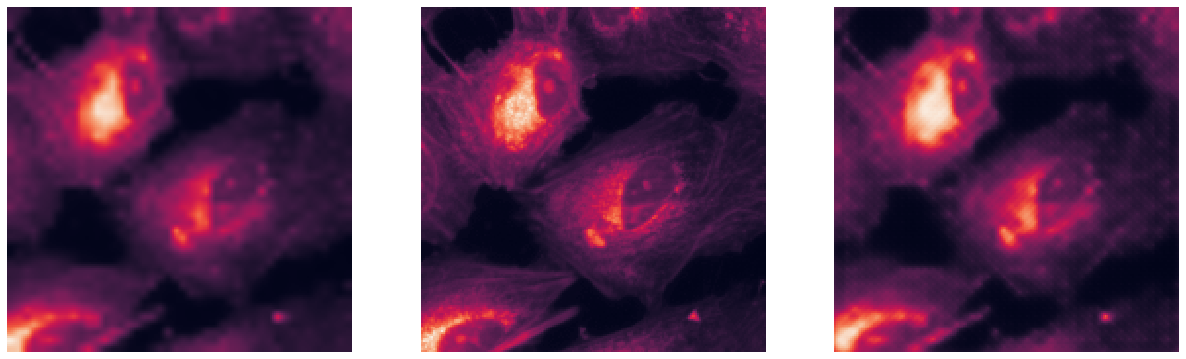

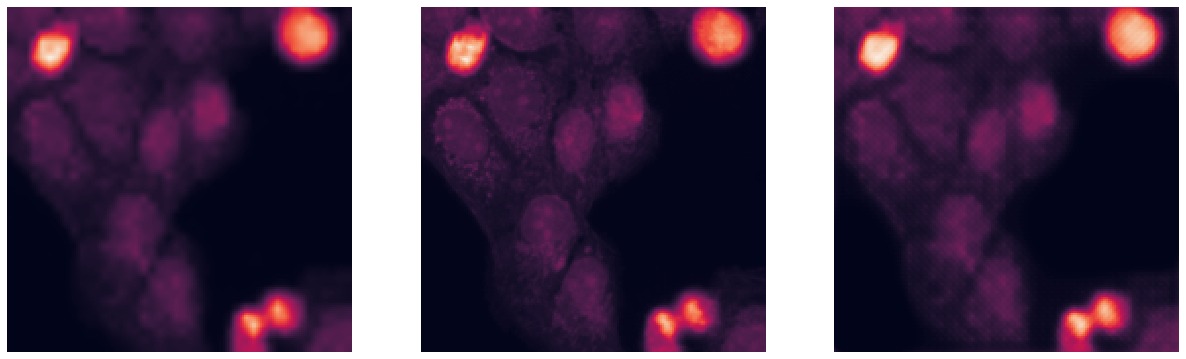

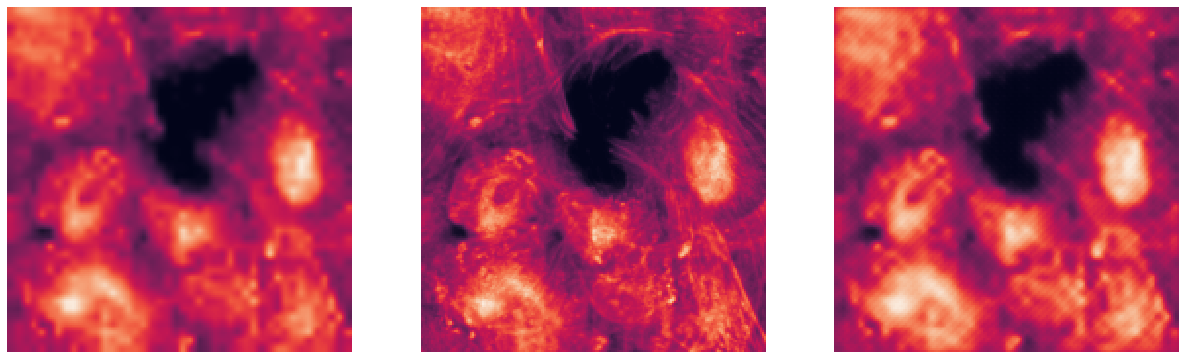

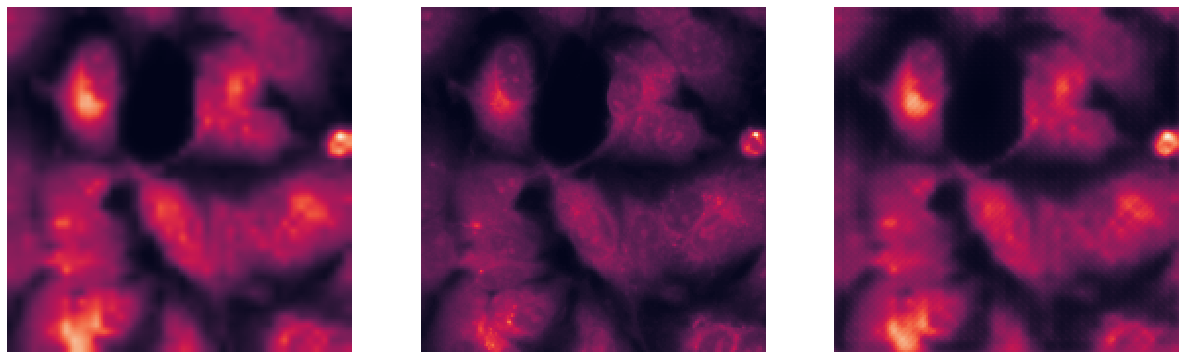

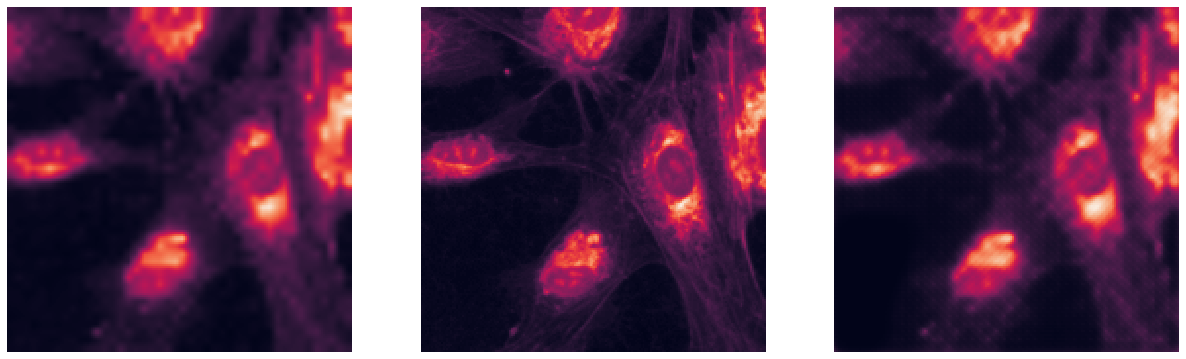

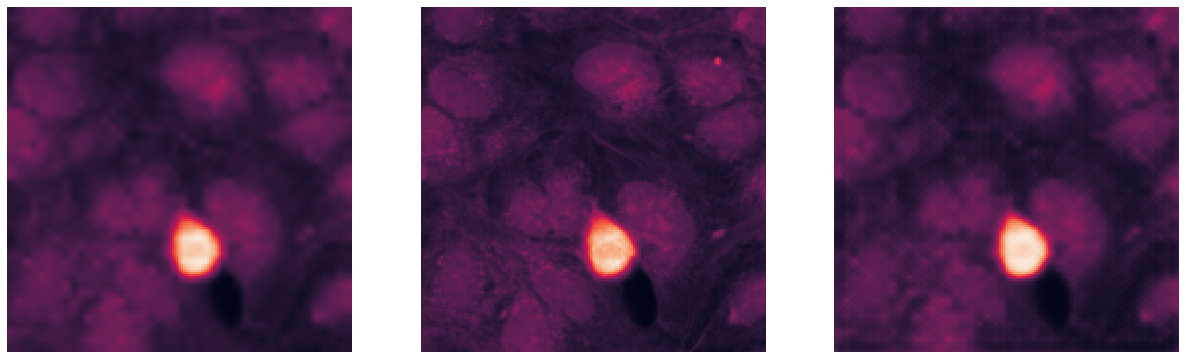

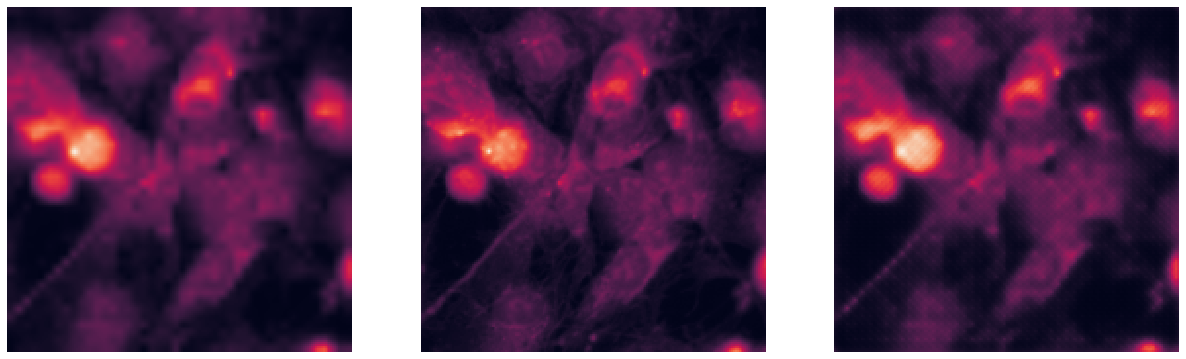

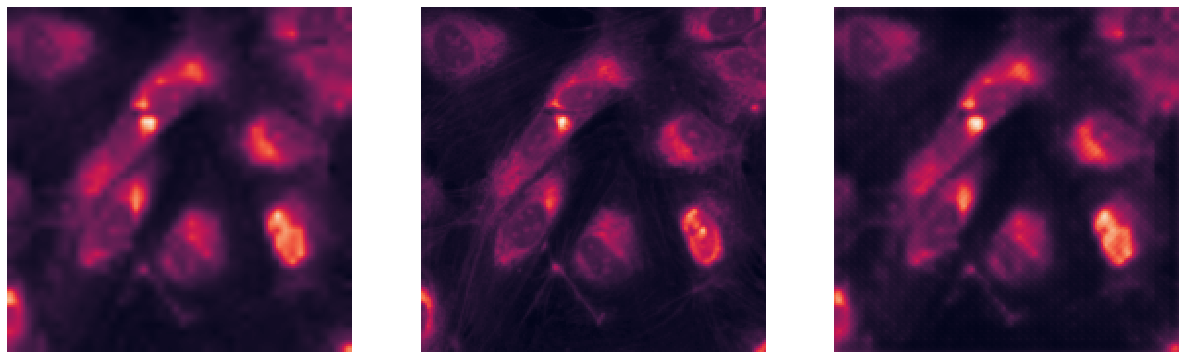

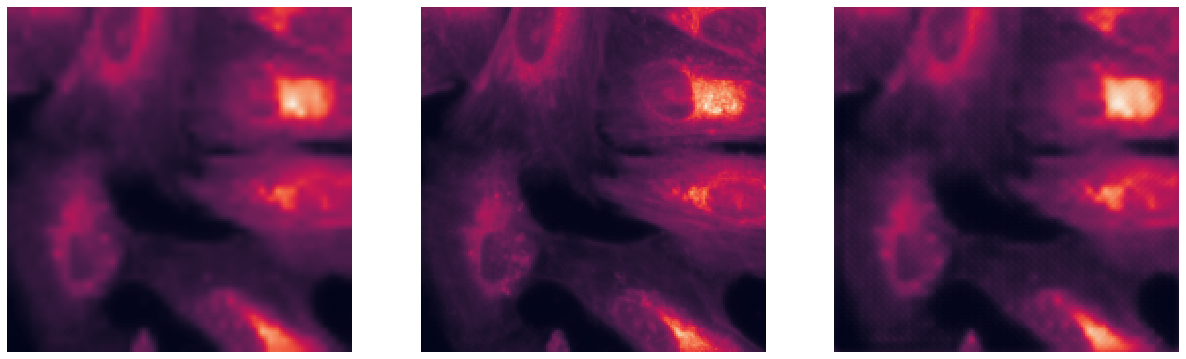

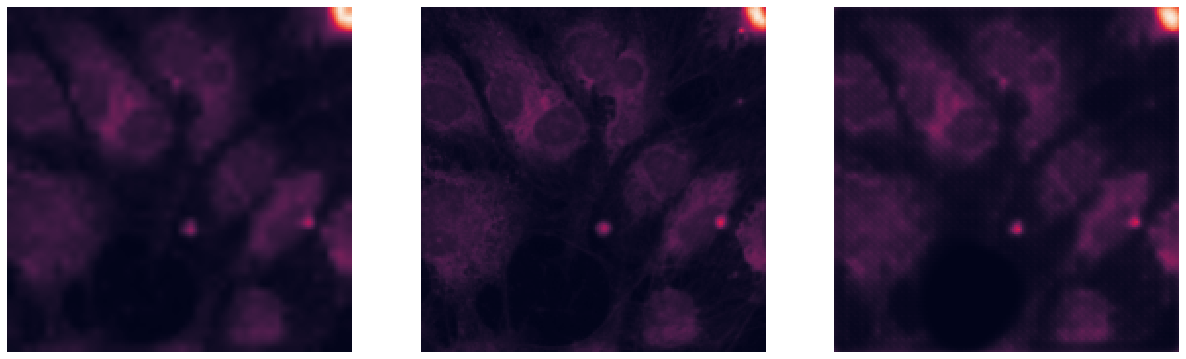

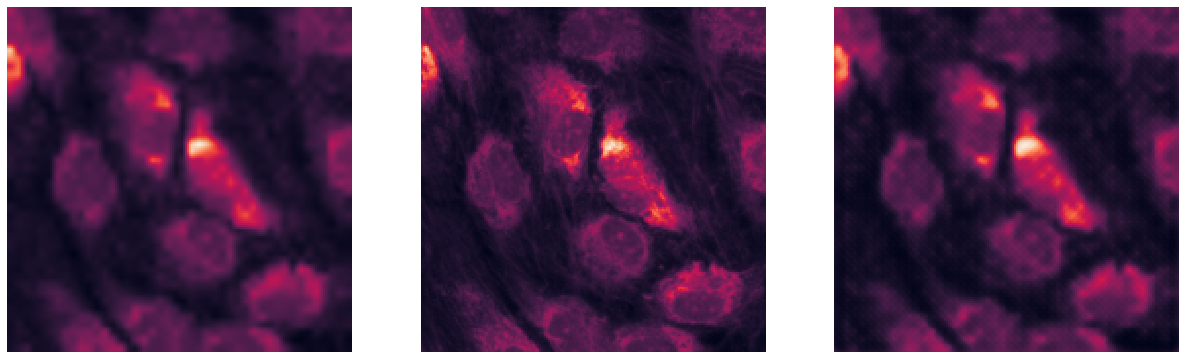

In [25]:
for epoch in range(2, config.PARAMS.NUM_EPOCHS):
    learner.train_on_epoch(train_loader, epoch)
    learner.validate(val_loader, epoch, PROCESS_DATA_DIR)
    
    for lr, hr in loader:
        break

    with torch.no_grad():
        batch_size = lr.size(0)
        lr = Variable(lr)
        if torch.cuda.is_available():
            lr = lr.cuda()

        learner.netG.eval()
        predict = learner.netG(lr)

    clear_output(wait=True)
    for i in range(lr.shape[0]):
        visualise(
            lr[i, 0].data.cpu().numpy(), 
            hr[i, 0].data.cpu().numpy(), 
            predict[i, 0].data.cpu().numpy())

[2/100] Loss_D: 0.9967 Loss_G: 0.0013 D(x): 0.5962 D(G(z)): 0.5928: 100%|██████████| 3635/3635 [39:19<00:00,  1.54it/s]
[converting LR images to SR images] PSNR: 33.7506 dB SSIM: 0.8893: 100%|██████████| 330/330 [00:17<00:00, 19.03it/s]
[saving training results]: 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


NameError: name 'results' is not defined

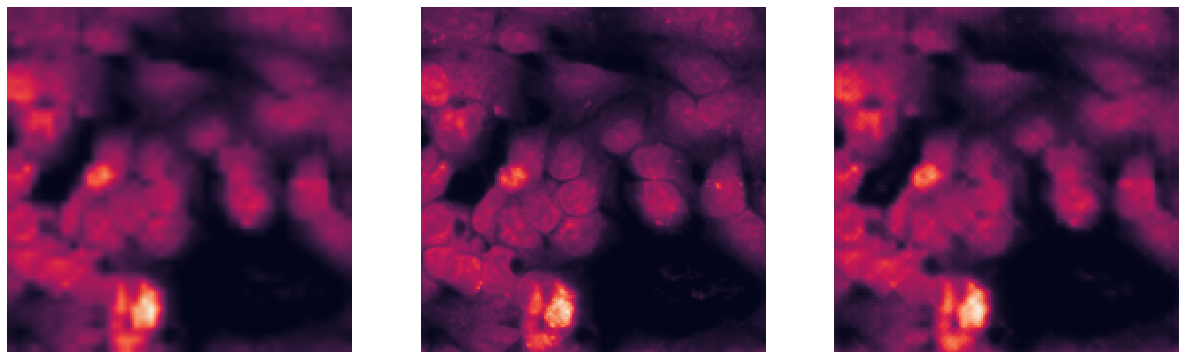

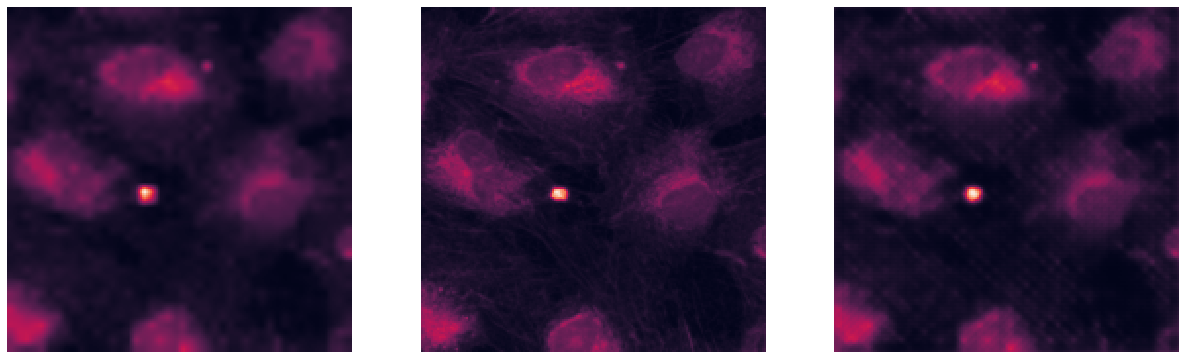

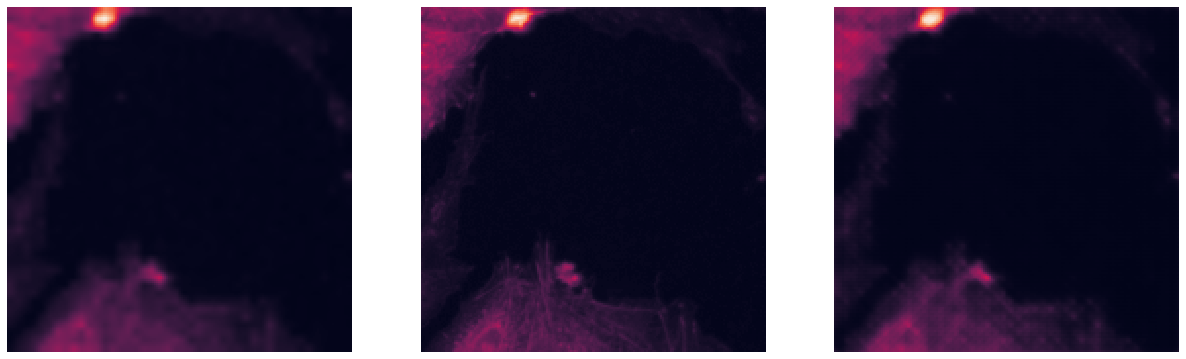

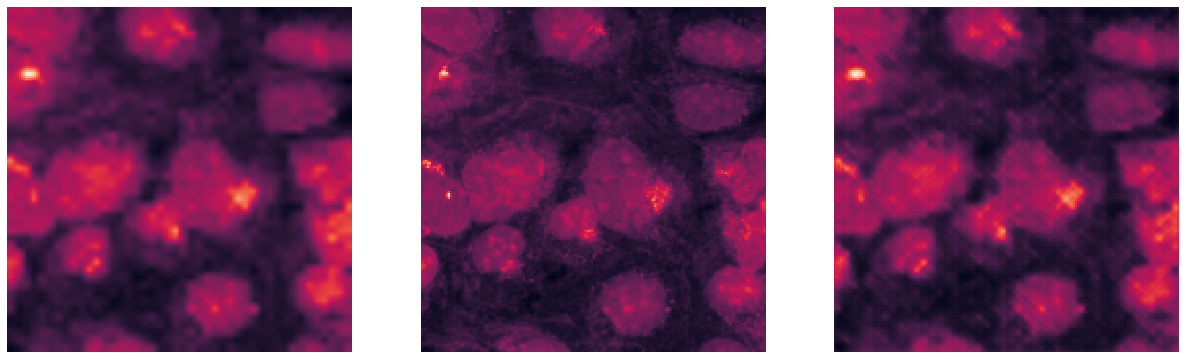

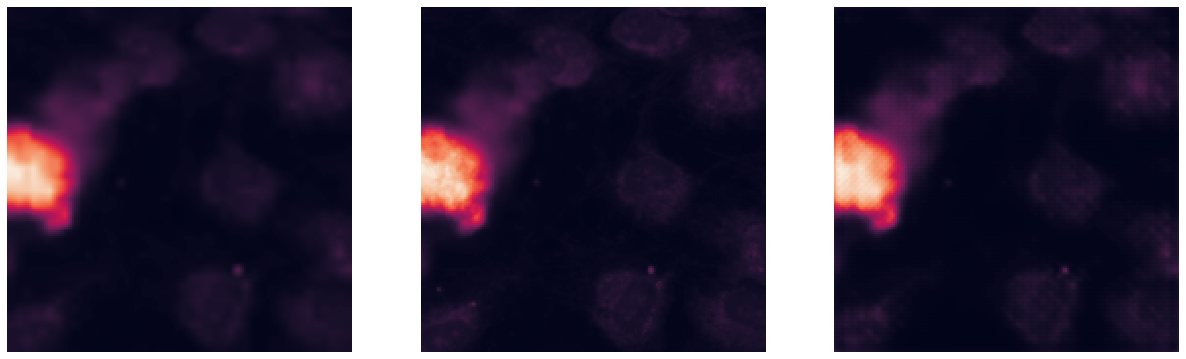

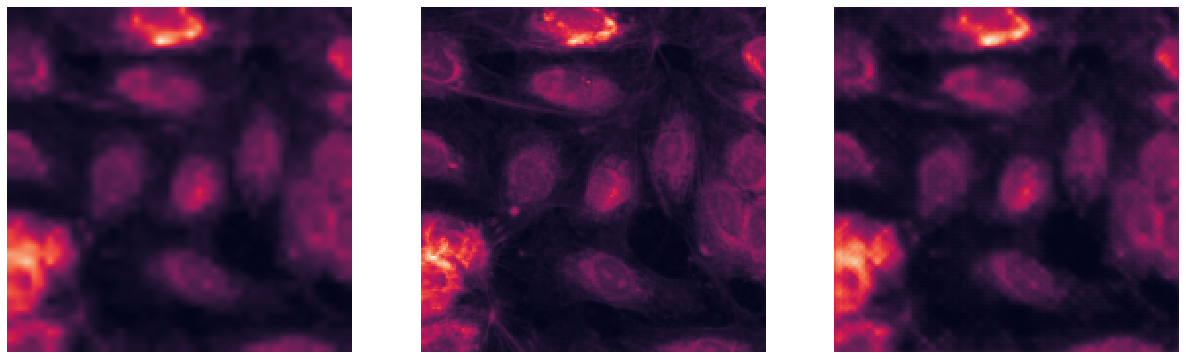

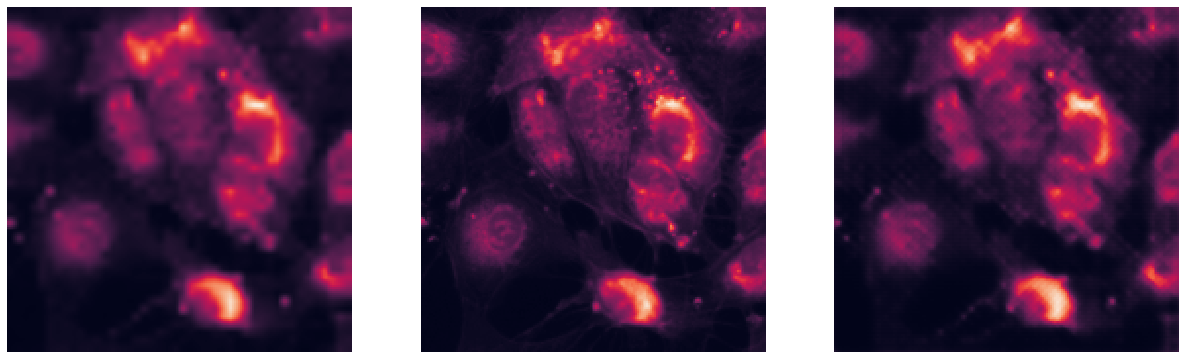

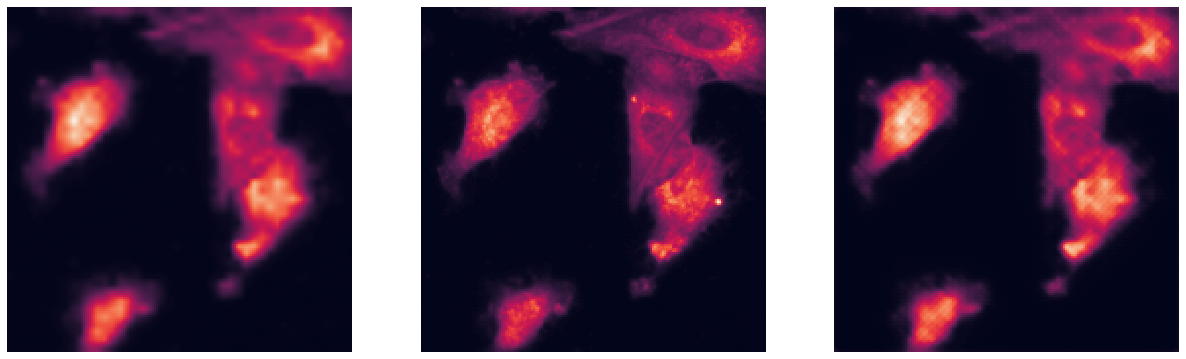

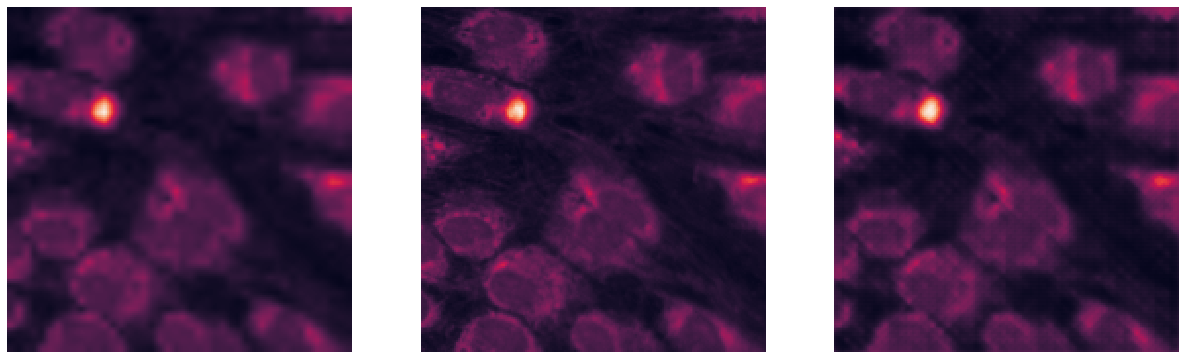

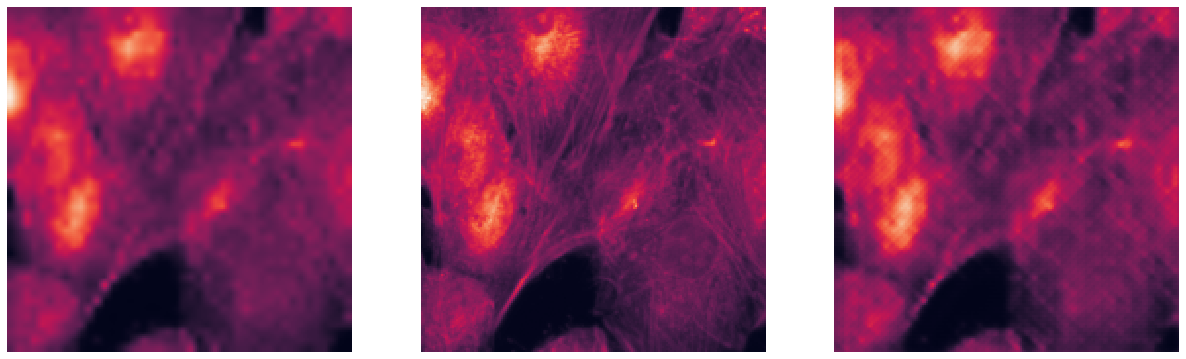

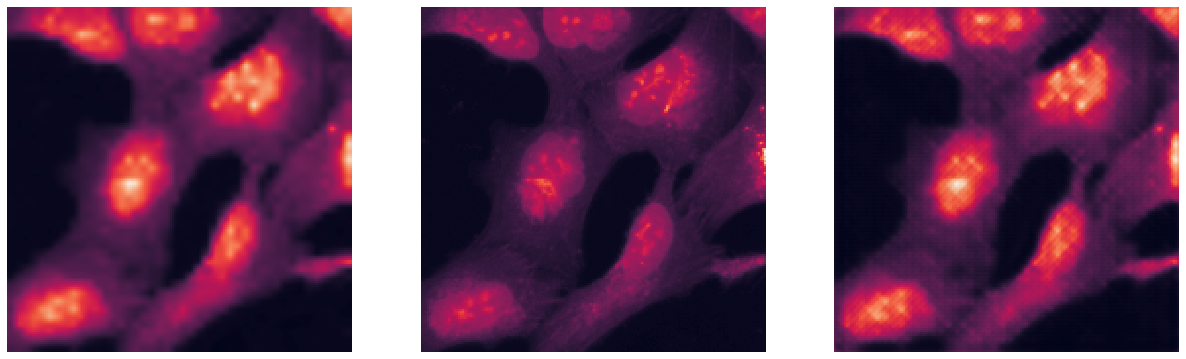

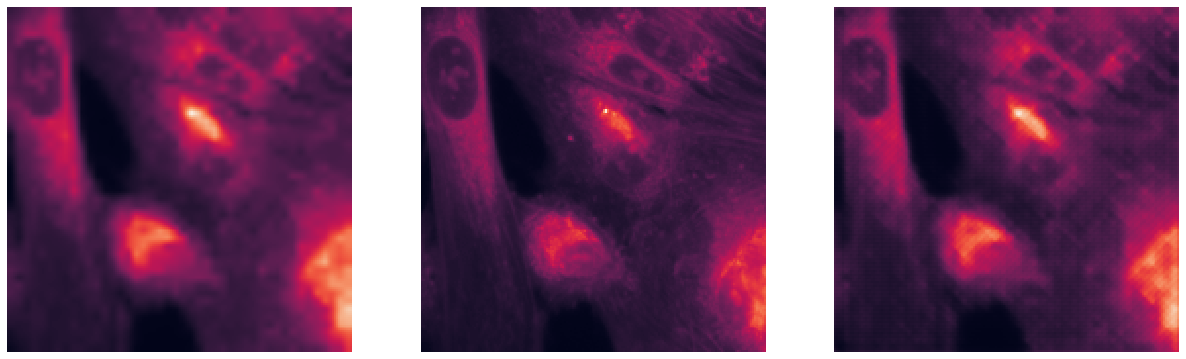

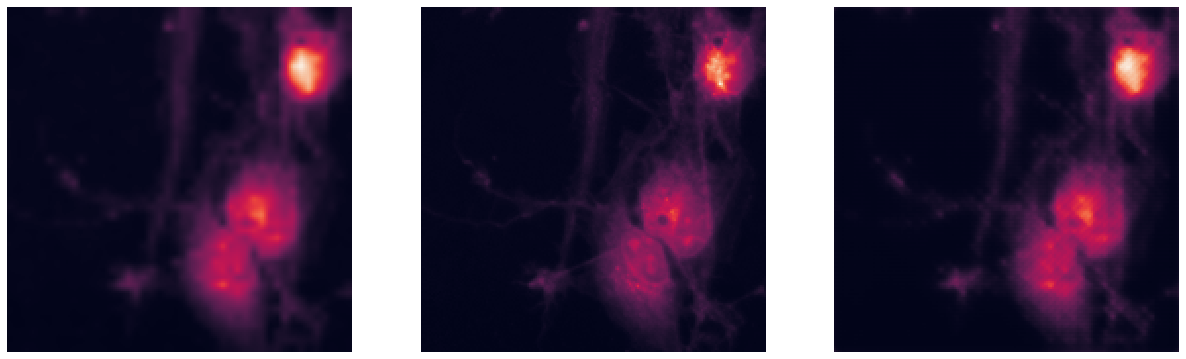

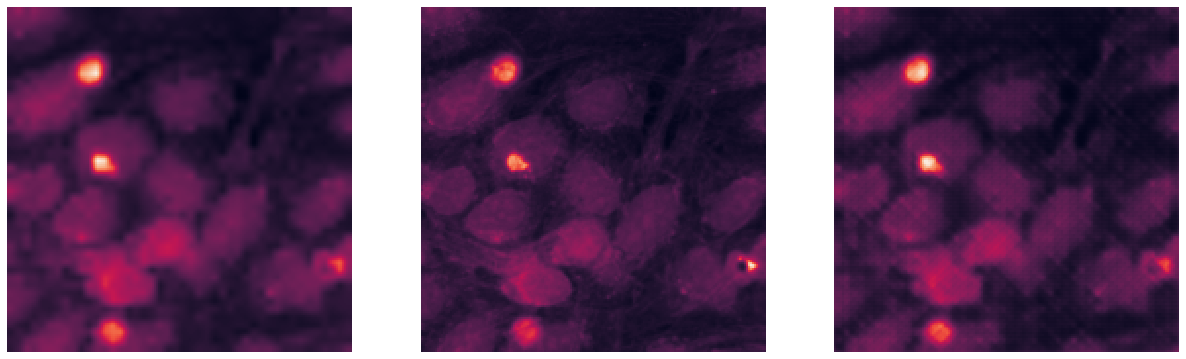

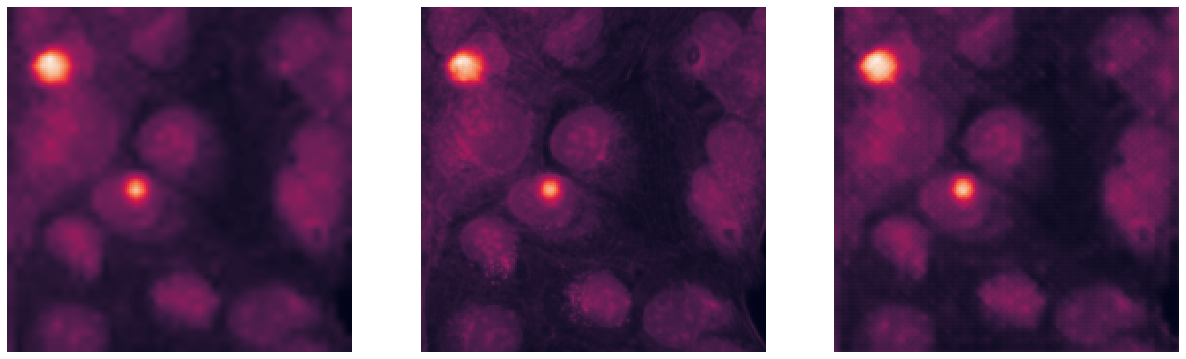

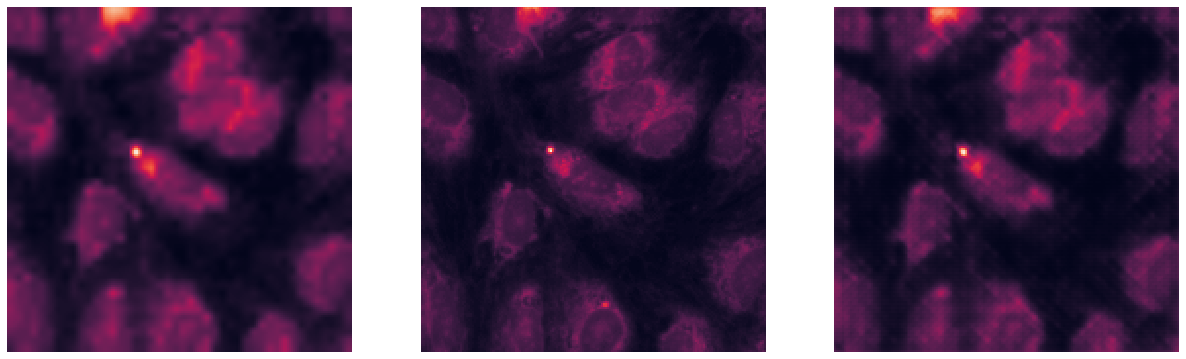

In [24]:
for lr, hr in loader:
    break

with torch.no_grad():
    batch_size = lr.size(0)
    lr = Variable(lr)
    if torch.cuda.is_available():
        lr = lr.cuda()

    learner.netG.eval()
    predict = learner.netG(lr)

clear_output(wait=True)
for i in range(lr.shape[0]):
    visualise(
        lr[i, 0].data.cpu().numpy(), 
        hr[i, 0].data.cpu().numpy(), 
        predict[i, 0].data.cpu().numpy())

In [19]:
plt.hist(predict.data.cpu().numpy()[0, 0][predict.data.cpu().numpy()[0, 0] != 0], 50);

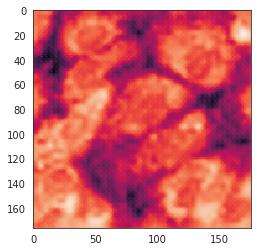

In [20]:
plt.imshow(np.log(predict.data.cpu().numpy()[0, 0])) 

In [11]:
a = plt.imshow(data[0][0, 0])
plt.colorbar(a)

#### 